In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from torchvision.transforms import RandomApply
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch.optim as optim
from tqdm import tqdm
from torchviz import make_dot

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Betöltés

In [3]:
data_dir = Path("../train")
subfolders = ["close_eyes", "open_eyes"]

files = []
for label in subfolders:
    folder = data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            files.append((str(file.resolve()), label))

#random.shuffle(files)

df = pd.DataFrame(files, columns=["filepath", "label"])

print("Összes tanító kép:", len(df))

Összes tanító kép: 81675


In [4]:
test_data_dir = Path("../test")
test_subfolders = ["close_eyes", "open_eyes"]

test_files = []
for label in test_subfolders:
    folder = test_data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            test_files.append((str(file.resolve()), label))

test_df = pd.DataFrame(test_files, columns=["filepath", "label"])
print("Összes teszt kép:", len(test_df))

Összes teszt kép: 3223


In [5]:
full_df = pd.concat([df, test_df], ignore_index=True)

lab = full_df["label"].value_counts()

labels = lab.index.map({
    "open_eyes": "Nyitott szemek",
    "close_eyes": "Zárt szemek"
})

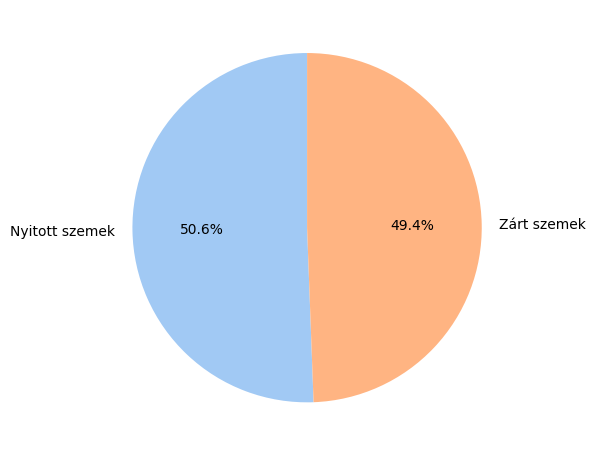

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(lab, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("pastel")[0:2])
#plt.title("Osztályok eloszlása a teljes adathalmazban", fontsize=13)
plt.tight_layout()
plt.show()

Előkészítés

In [7]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    #transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.05, 0.05))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
class EyesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"close_eyes": 0, "open_eyes": 1}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row["label"]]
        return img, label

In [9]:
BATCH = 32

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_dataset = EyesDataset(train_df, transform=transform_train)
val_dataset = EyesDataset(val_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Train: 65340, Validation: 16335


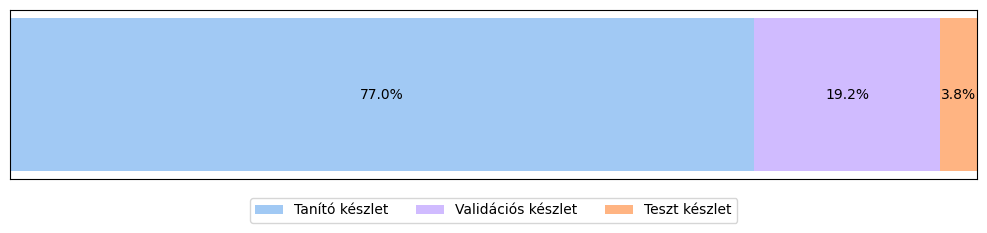

In [10]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

train_ratio = train_size / total
val_ratio = val_size / total
test_ratio = test_size / total

fig, ax = plt.subplots(figsize=(10, 2.5))

ax.barh(0, train_ratio, color="#A1C9F4", label="Tanító készlet")
ax.barh(0, val_ratio, left=train_ratio, color="#D0BBFF", label="Validációs készlet")
ax.barh(0, test_ratio, left=train_ratio + val_ratio, color="#FFB482", label="Teszt készlet")

ax.text(train_ratio / 2, 0, f"{train_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio / 2, 0, f"{val_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio + test_ratio / 2, 0, f"{test_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 1)
#ax.set_title("Adathalmaz megoszlása", fontsize=12)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.show()


Model

In [11]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EyeCNN().to(device)

In [12]:
x = torch.randn(1, 1, 224, 224).to(device)

output = model(x)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture', cleanup=True)

'model_architecture.png'

In [13]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=0.00005, 
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3, 
                                                 verbose=True)

In [14]:
num_epochs = 20
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # paraméterek frissítése

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_preds.extend(preds.cpu().numpy().flatten().tolist())
        train_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Training Accuracy: {acc:.4f}")

    # Validáció
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy().flatten().tolist())
            val_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation: Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    scheduler.step(avg_val_loss)  # tanulási ráta frissítése

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print("Stop")
        break


Training Epoch 1/20: 100%|██████████| 2042/2042 [12:07<00:00,  2.81it/s]  


Epoch 1: Loss: 0.2437, Training Accuracy: 0.9061
Validation: Loss: 0.1630, Accuracy: 0.9409


Training Epoch 2/20: 100%|██████████| 2042/2042 [01:10<00:00, 29.02it/s]


Epoch 2: Loss: 0.1597, Training Accuracy: 0.9429
Validation: Loss: 0.1314, Accuracy: 0.9556


Training Epoch 3/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.92it/s]


Epoch 3: Loss: 0.1355, Training Accuracy: 0.9532
Validation: Loss: 0.1111, Accuracy: 0.9622


Training Epoch 4/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.89it/s]


Epoch 4: Loss: 0.1226, Training Accuracy: 0.9571
Validation: Loss: 0.1030, Accuracy: 0.9638


Training Epoch 5/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.77it/s]


Epoch 5: Loss: 0.1136, Training Accuracy: 0.9609
Validation: Loss: 0.0962, Accuracy: 0.9676


Training Epoch 6/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.86it/s]


Epoch 6: Loss: 0.1040, Training Accuracy: 0.9635
Validation: Loss: 0.0862, Accuracy: 0.9691


Training Epoch 7/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.84it/s]


Epoch 7: Loss: 0.0975, Training Accuracy: 0.9652
Validation: Loss: 0.0801, Accuracy: 0.9719


Training Epoch 8/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.78it/s]


Epoch 8: Loss: 0.0919, Training Accuracy: 0.9673
Validation: Loss: 0.0737, Accuracy: 0.9739


Training Epoch 9/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.89it/s]


Epoch 9: Loss: 0.0860, Training Accuracy: 0.9696
Validation: Loss: 0.0704, Accuracy: 0.9742


Training Epoch 10/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.84it/s]


Epoch 10: Loss: 0.0803, Training Accuracy: 0.9714
Validation: Loss: 0.0644, Accuracy: 0.9766


Training Epoch 11/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.76it/s]


Epoch 11: Loss: 0.0770, Training Accuracy: 0.9728
Validation: Loss: 0.0616, Accuracy: 0.9780


Training Epoch 12/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.79it/s]


Epoch 12: Loss: 0.0722, Training Accuracy: 0.9738
Validation: Loss: 0.0625, Accuracy: 0.9783


Training Epoch 13/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.77it/s]


Epoch 13: Loss: 0.0674, Training Accuracy: 0.9762
Validation: Loss: 0.0545, Accuracy: 0.9807


Training Epoch 14/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.68it/s]


Epoch 14: Loss: 0.0631, Training Accuracy: 0.9781
Validation: Loss: 0.0533, Accuracy: 0.9822


Training Epoch 15/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.61it/s]


Epoch 15: Loss: 0.0600, Training Accuracy: 0.9781
Validation: Loss: 0.0535, Accuracy: 0.9811


Training Epoch 16/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.55it/s]


Epoch 16: Loss: 0.0571, Training Accuracy: 0.9806
Validation: Loss: 0.0504, Accuracy: 0.9822


Training Epoch 17/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.62it/s]


Epoch 17: Loss: 0.0562, Training Accuracy: 0.9801
Validation: Loss: 0.0538, Accuracy: 0.9792


Training Epoch 18/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.51it/s]


Epoch 18: Loss: 0.0531, Training Accuracy: 0.9815
Validation: Loss: 0.0488, Accuracy: 0.9832


Training Epoch 19/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.63it/s]


Epoch 19: Loss: 0.0513, Training Accuracy: 0.9817
Validation: Loss: 0.0508, Accuracy: 0.9827


Training Epoch 20/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.62it/s]


Epoch 20: Loss: 0.0492, Training Accuracy: 0.9826
Validation: Loss: 0.0438, Accuracy: 0.9855


In [15]:
val_precision = precision_score(val_labels, val_preds, zero_division=0)
val_recall = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

Precision: 0.9829
Recall: 0.9885
F1-score: 0.9857


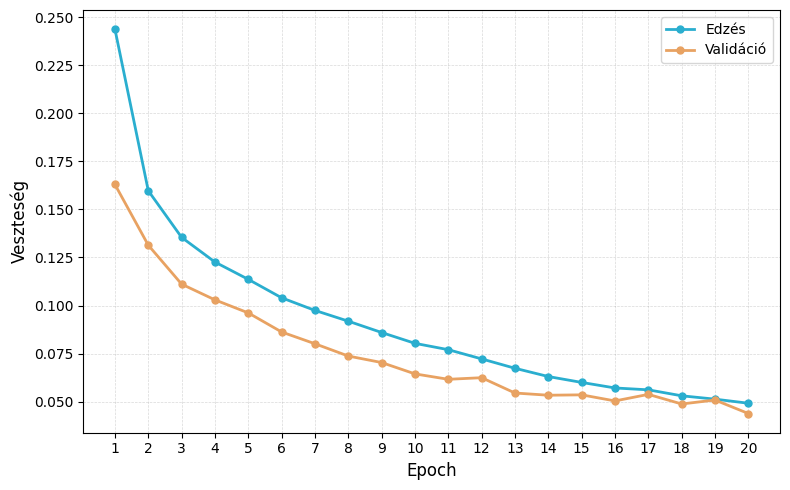

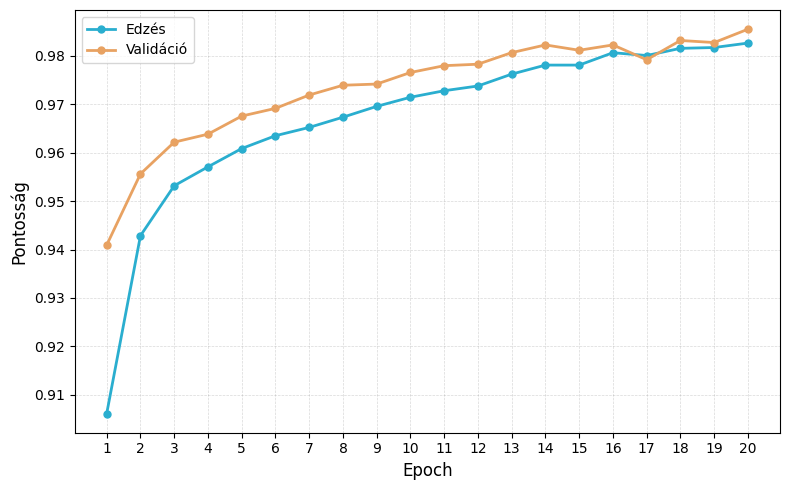

In [22]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_losses, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Veszteség", fontsize=12)
#plt.title("Veszteség alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_accuracies, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Pontosság", fontsize=12)
#plt.title("Pontosság alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Test

In [17]:
test_dataset = EyesDataset(test_df, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
model.eval()
running_test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy().flatten().tolist())
        test_labels.extend(labels.cpu().numpy().flatten().tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, zero_division=0)
test_recall = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)

print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

Precision: 0.9964
Recall: 0.8413
F1-score: 0.9123


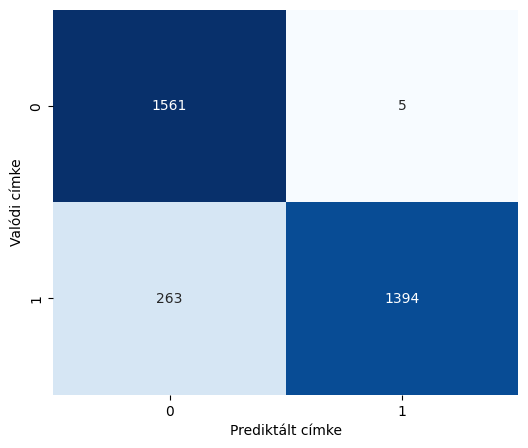

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prediktált címke')
plt.ylabel('Valódi címke')
#plt.title('Konfúziós mátrix a teszthalmazon')
plt.show()

Mentés

In [ ]:
#torch.save(model.state_dict(), "test7cnn.pth")
#print("modell mentve")

modell mentve
